In [1]:
import numpy as np
import torch
from torch import nn
import networkx as nx
import copy
import circuits as ckt

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(1 , 0), (1 , 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': 0, 'i': None, 'v': None, 'attr': 2}), (1, 0, 1, {'kind': 1, 'i': 0.5, 'v': None, 'attr': None})]


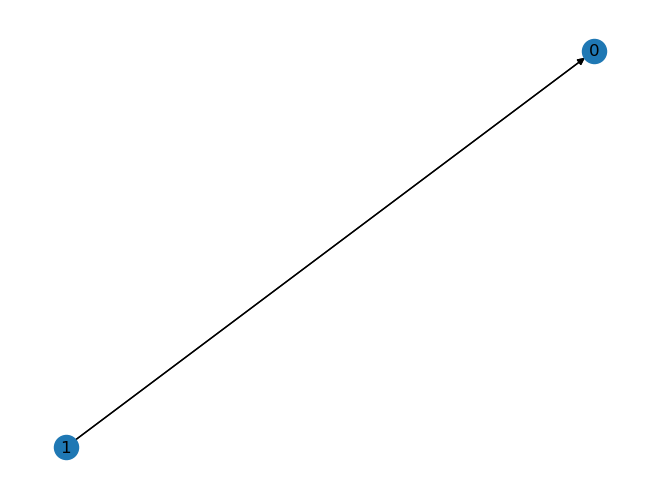

In [3]:
vr = ckt.Circuit()
v_source = vr.add_element(kind=ckt.Kinds.IVS.value)
resistor = vr.add_element(kind=ckt.Kinds.R.value)
v_source.connect(v_source.high, resistor.high)
v_source.connect(v_source.low, resistor.low)
v_source.attr = 2
resistor.i = 0.5
# v_source.low.p = 0
print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Expected Sizes of Vectors

In [4]:
print(f'size of element currents, voltages, and attr = ({vr.num_elements()},1)')
print(f'size of node voltages = ({vr.num_nodes()},1)')

size of element currents, voltages, and attr = (2,1)
size of node voltages = (2,1)


# Inputs

In [5]:
input_test = ckt.Input(vr)

c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:77: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [6]:
input_test.M

tensor([[-1., -1.],
        [ 1.,  1.]])

# Circuit Theory Functions

In [7]:
input_test.init_tensors()

(tensor([[0.0000],
         [0.5000]]),
 tensor([[0.],
         [0.]]),
 tensor([[0.],
         [0.]]),
 tensor([[2.],
         [1.]]))

In [8]:
~input_test.known_masks()[3].to(torch.bool)

tensor([[False],
        [ True]])

In [9]:
input_test.element_row(input_test.init_tensors()[3])

tensor([[ 0.,  0.,  1.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  1.,  0.,  0.]])

In [10]:
input_test.kind_map()

{0: tensor([[1.],
         [0.]]),
 1: tensor([[0.],
         [1.]])}

In [11]:
mask = torch.tensor([[True],
                    [True]], dtype=torch.bool)
mask

tensor([[True],
        [True]])

In [12]:
test_tensor = torch.tensor([[10],
                    [20]])
test_tensor

tensor([[10],
        [20]])

In [13]:
test_tensor[~mask] = 4
test_tensor

tensor([[10],
        [20]])

In [14]:
input_test.s()

tensor([[2.],
        [0.]])

# Define Models

In [15]:
class Solve(nn.Module):
    ''' 
    Sparse Tableau Formulation of circuit analysis, modeled as a machine learning
    problem to learn element attributes using backprop and optimization.
    '''
    def __init__(self, input: ckt.Input):
        super().__init__()
        self.input = input
        _, _, _, attr_in = self.input.init_tensors()
        self.attr = nn.Parameter(attr_in.clone().detach())

    def forward(self):
        A,b = self.build()
        solution = torch.linalg.lstsq(A,b).solution
        #calc_attr = self.calc_attrs(solution)
        return solution#, calc_attr
            
    def zero_known_grads(self):
        _,_,_,attr = self.input.known_masks()
        self.attr.grad[attr.to(torch.bool)] = 0

    def build(self):
        # inputs
        i_in, v_in, _, attr_in = self.input.init_tensors()
        kind_map = self.input.kind_map()
        is_s_mask = kind_map[ckt.Kinds.IVS.value]
        is_r_mask = kind_map[ckt.Kinds.R.value]
        _,_,_,attr_known = self.input.known_masks()
        attr_known = attr_known.to(torch.bool)
        is_r_mask_z, is_r_mask_y, is_s_mask_y = self.input.rs_mask(kind_map)
        s = self.input.s()
        M = self.input.M
        num_elements = M.shape[1]
                
        # A matrix
        kcl_row = torch.cat(tensors=(M,
                                    torch.zeros_like(M),
                                    torch.zeros_like(M)),dim=1)
        kvl_row = torch.cat(tensors=(torch.zeros_like(M),
                                    torch.eye(num_elements),
                                    -M.T),dim=1)
        # e_row = self.input.element_row()
        e_row = self.input.element_row(self.attr)
        A = torch.cat(tensors=(kcl_row,kvl_row,e_row), dim=0)

        # b matrix
        kcl_zeros = torch.zeros_like(i_in)
        kvl_zeros = torch.zeros_like(v_in)
        b = torch.cat(tensors=(kvl_zeros,kcl_zeros,s), dim=0)
        
        return A,b

    def calc_attrs(self, solution: torch.Tensor):
        kind_masks = self.input.kind_map()
        ivs_mask: torch.Tensor = kind_masks[ckt.Kinds.IVS.value].to(torch.bool)
        r_mask: torch.Tensor  = kind_masks[ckt.Kinds.R.value].to(torch.bool)
        num_elements = r_mask.shape[0]
        
        i = solution[:num_elements,:]
        v = solution[num_elements:2*num_elements,:]
        
        ret_attrs = torch.zeros(size=(num_elements,1))

        ret_attrs[ivs_mask] = v[ivs_mask]
        ret_attrs[r_mask] = v[r_mask]/i[r_mask]

        return ret_attrs

    # def attr_error(self, calc_attrs):
    #     _, _, _, mask = self.input.known_masks()
    #     _, _, _, pred_attrs = self.attr()
    #     attrs[mask.to(torch.bool)]
    #     return truths[mask.to(torch.bool)] - 

# Create Instance of Models

In [16]:
input = ckt.Input(vr)
model = Solve(input=input)
list(model.parameters())

[Parameter containing:
 tensor([[2.],
         [1.]], requires_grad=True)]

# Loss

In [17]:
loss_fn = nn.MSELoss()

# Optimizer

In [18]:
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.1)

# Train Function

# Test Function 

No inference therefore no testing!

# Run Train Loop

In [19]:
def loss_mask():
    # _, _, _, attr_known = input.known_masks()
    # attr_bool = attr_known.to(torch.bool)
    # return attr_bool
    masks = input.known_masks()
    mask_list = []
    for m in range(len(masks)):
        if(m==2):
            continue
        mask_list.append(masks[m].to(torch.bool))
    mask_tuple = tuple(mask_list)
    return torch.cat(tensors=(mask_tuple))

In [20]:
def truth_vals():
    # _, _, _, attr_in = input.init_tensors()
    # return attr_in
    truths = input.init_tensors()
    truth_list = []
    for m in range(len(truths)):
        if(m==2):
            continue
        truth_list.append(truths[m])
    truth_tuple = tuple(truth_list)
    return torch.cat(tensors=(truth_tuple))

In [21]:
loss_mask()

tensor([[False],
        [ True],
        [False],
        [False],
        [ True],
        [False]])

In [22]:
truth_vals()[loss_mask()]

tensor([0.5000, 2.0000])

In [23]:
epochs = 10000

prev_loss = 0.1
lt_prev_loss = 1000

true_vals = truth_vals()

knowns_mask = loss_mask()

for t in range(epochs):

    #set training mode
    model.train()

    pred = model()
    loss = loss_fn(pred[knowns_mask], true_vals[knowns_mask])

    model.zero_grad()

    # loss.backward(retain_graph=True)
    loss.backward(retain_graph=False)

    model.zero_known_grads()

    optimizer.step()

    # analyze steps and loss
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

    if (t % (epochs/10)) == 0:
        # print(f'epoch {t} loss = {max_loss} ({loss_change} per unit change)')
        print(f'epoch {t} loss: {loss.item()}')
        if loss > lt_prev_loss:
            for g in optimizer.param_groups:
                g['lr'] /= 2
            # print(f'reducing kcl learning rate')
        lt_prev_loss = loss

    if (loss_change < 1e-30):
        print(f'epoch {t} loss = {loss} finished early for loss change')
        break

    if loss < 1e-10:
        print(f'epoch {t} loss = {loss} finished early for loss threshold')
        break

print("Done!")
print(f'pred {pred}')
print(f'truth {true_vals[knowns_mask]}')
print(f'attr {list(model.parameters())}')
print(f'pred known {pred[knowns_mask]}')
print(f'true vals known {true_vals[knowns_mask]}')

epoch 0 loss: 5.625000953674316
epoch 340 loss = 4.500120639801025 finished early for loss change
Done!
pred tensor([[-0.5154],
        [ 0.5154],
        [ 2.0000],
        [ 2.0000],
        [-1.0000],
        [ 1.0000]], grad_fn=<LinalgLstsqBackward0>)
truth tensor([0.5000, 2.0000])
attr [Parameter containing:
tensor([[2.0000],
        [3.8812]], requires_grad=True)]
pred known tensor([ 0.5154, -1.0000], grad_fn=<IndexBackward0>)
true vals known tensor([0.5000, 2.0000])


In [24]:
loss = nn.MSELoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5)
output = loss(input, target)
output.backward()

In [25]:
output.item()

2.0656442642211914